In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
from numpy import round
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

from timeit import default_timer as timer
from tqdm.auto import tqdm

## 1. Dataset

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

print(train_data)
print(test_data)

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.1MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 347kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 6.17MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 4.26MB/s]


Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


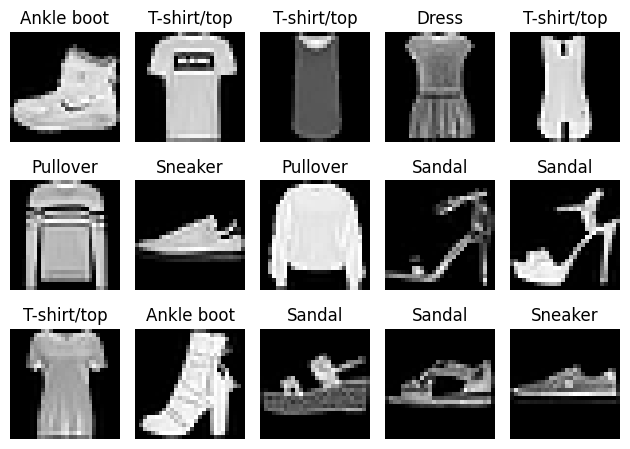

In [3]:
r, c = 3, 5
for i in range(r*c):
  plt.subplot(r, c, i+1)
  image, label = train_data[i]
  plt.imshow(image.squeeze(), cmap="gray")
  plt.title(train_data.classes[label])
  plt.axis(False)
  plt.tight_layout()

## 2. DataLoader

In [3]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [5]:
single_batch = next(iter(train_dataloader))
print(single_batch[0].shape) # Data
print(single_batch[1].shape) # Labels

torch.Size([32, 1, 28, 28])
torch.Size([32])


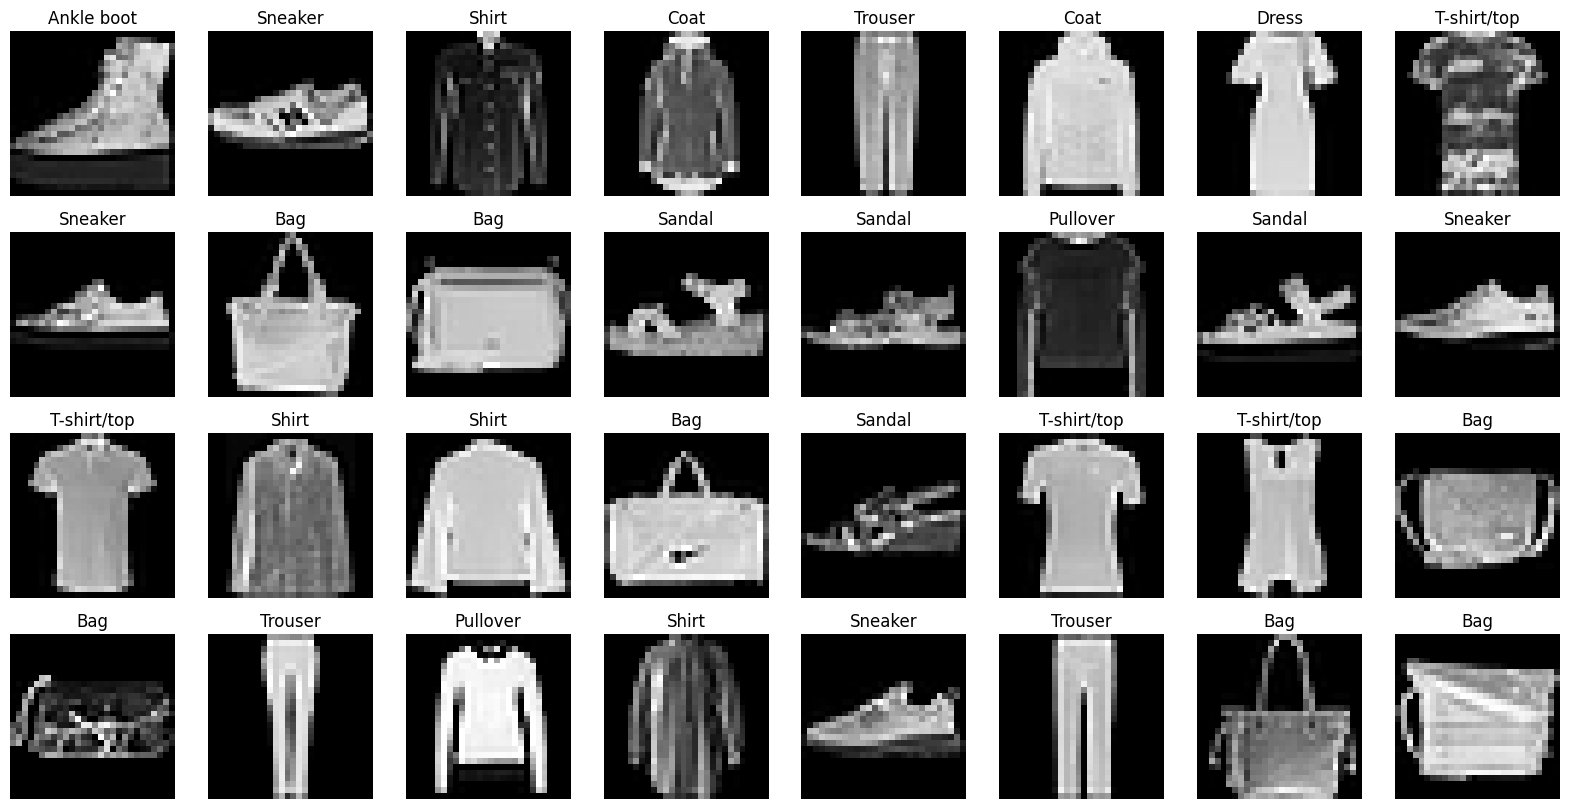

In [6]:
plt.figure(figsize=(20, 10))
data = single_batch[0]
label = single_batch[1]
for i in range(len(label)):
  plt.subplot(4, 8, i+1)
  plt.imshow(data[i].squeeze(), cmap="gray")
  plt.title(train_data.classes[label[i]])
  plt.axis(False)

## 3. Initial Model

In [8]:
print(single_batch[0].shape)
flatten_layer = nn.Flatten()
print(flatten_layer(single_batch[0]).shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 784])


In [9]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
      return self.layer_stack(x)

In [10]:
model_0 = FashionMNISTModelV1(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(train_data.classes)
)
model_0

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [11]:
print(f"Shape after forward a single batch: {model_0(single_batch[0]).shape}")

Shape after forward a single batch: torch.Size([32, 10])


## 4. Loss and Optimizer

In [12]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_0.parameters(),
    lr=0.01
    )

In [13]:
with torch.inference_mode():
  print("Out:")
  print("model(x) = logits =", model_0(single_batch[0])[0])
  print("y =", single_batch[1][0])
  print("loss(logits, y) =", loss_fn(model_0(single_batch[0])[0], single_batch[1][0]))

Out:
model(x) = logits = tensor([ 0.0064, -0.1100, -0.1471, -0.0299, -0.1521,  0.4446,  0.0082,  0.3323,
        -0.1060,  0.2472])
y = tensor(1)
loss(logits, y) = tensor(2.4837)


## 5. Training

In [4]:
SEED = 42
EPOCHS = 5
EPOCH_FREQ_PRINT = 1/5

device = "cpu"

In [5]:
def fit(model, train_dataloader, loss_fn, optimizer):
  torch.manual_seed(SEED)
  start_t = timer()

  for epoch in tqdm(range(EPOCHS)):

    train_loss, train_acc = 0, 0

    # Pass through all batches
    for batch, (X, y) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
      X, y = X.to(device), y.to(device)

      model.train()

      # 1. Forward
      y_logits = model(X)

      # 2. Loss
      loss = loss_fn(y_logits, y)
      train_loss += loss
      train_acc += accuracy_score(y.cpu(), y_logits.cpu().argmax(dim=1))

      # 3. Backward
      optimizer.zero_grad()
      loss.backward()

      # 4. Optimizer step
      optimizer.step()

    # Test model
    if epoch % round(EPOCHS * EPOCH_FREQ_PRINT) == 0:
      test_loss, test_acc = 0, 0
      model.eval()
      with torch.inference_mode():
        for X, y in test_dataloader:
          X, y = X.to(device), y.to(device)
          test_logits = model(X)

          test_loss += loss_fn(test_logits, y)
          test_acc += accuracy_score(y.cpu(), test_logits.cpu().argmax(dim=1))

      train_loss = train_loss / len(train_dataloader)
      train_acc = train_acc / len(train_dataloader)
      test_loss = test_loss / len(test_dataloader)
      test_acc = test_acc / len(test_dataloader)

      print(f"--- Epoch: {epoch} ---")
      print(f"Train loss: {train_loss}, Train acc: {train_acc}")
      print(f"Test loss: {test_loss}, Test acc: {test_acc}")

  end_t = timer()
  print(f"Total training time: {end_t - start_t}")

In [16]:
fit(model_0, train_dataloader, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 0 ---
Train loss: 0.8953479528427124, Train acc: 0.7066833333333333
Test loss: 0.648176908493042, Test acc: 0.7806509584664537


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 1 ---
Train loss: 0.5720295310020447, Train acc: 0.8079666666666667
Test loss: 0.5523412823677063, Test acc: 0.8108027156549521


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 2 ---
Train loss: 0.5084145069122314, Train acc: 0.8265166666666667
Test loss: 0.5167154669761658, Test acc: 0.8202875399361023


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 3 ---
Train loss: 0.4789026081562042, Train acc: 0.8353333333333334
Test loss: 0.49570828676223755, Test acc: 0.8276757188498403


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 4 ---
Train loss: 0.4617072343826294, Train acc: 0.8407
Test loss: 0.48409318923950195, Test acc: 0.8305710862619808
Total training time: 68.75649678799999


## 6. Improving the model

In [17]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU(),
            nn.Linear(in_features=output_shape, out_features=output_shape)
        )

    def forward(self, x):
      return self.layer_stack(x)

In [18]:
device = 'cpu'

In [19]:
model_1 = FashionMNISTModelV2(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(train_data.classes)
)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.01
    )

In [20]:
next(model_1.parameters()).device

device(type='cpu')

In [21]:
fit(model_1, train_dataloader, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 0 ---
Train loss: 1.1810249090194702, Train acc: 0.5713833333333334
Test loss: 0.7275048494338989, Test acc: 0.7325279552715654


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 1 ---
Train loss: 0.6344259977340698, Train acc: 0.7712166666666667
Test loss: 0.5918146967887878, Test acc: 0.7887380191693291


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 2 ---
Train loss: 0.5452471971511841, Train acc: 0.8086166666666667
Test loss: 0.5424567461013794, Test acc: 0.8065095846645367


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 3 ---
Train loss: 0.503767192363739, Train acc: 0.8223
Test loss: 0.5109944939613342, Test acc: 0.8203873801916933


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 4 ---
Train loss: 0.47748538851737976, Train acc: 0.8309333333333333
Test loss: 0.49994003772735596, Test acc: 0.8201876996805112
Total training time: 63.603591779


## 7. Speeding up

Or not...

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [26]:
model_1 = FashionMNISTModelV2(
    input_shape=28*28,
    hidden_units=16,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_1.parameters(),
    lr=0.001,
    )

In [27]:
next(model_1.parameters()).device

device(type='cuda', index=0)

In [28]:
fit(model_1, train_dataloader, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 0 ---
Train loss: 0.671441912651062, Train acc: 0.7677666666666667
Test loss: 0.5068094730377197, Test acc: 0.8256789137380192


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 1 ---
Train loss: 0.4603649079799652, Train acc: 0.8395666666666667
Test loss: 0.4747033715248108, Test acc: 0.832667731629393


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 2 ---
Train loss: 0.4270605444908142, Train acc: 0.8513
Test loss: 0.44803401827812195, Test acc: 0.8438498402555911


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 3 ---
Train loss: 0.4080088138580322, Train acc: 0.8575
Test loss: 0.4407689869403839, Test acc: 0.8470447284345048


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 4 ---
Train loss: 0.39605027437210083, Train acc: 0.8609
Test loss: 0.43107298016548157, Test acc: 0.8494408945686901
Total training time: 74.82270051199998


## 8. Convolutional Network

Modelo apropriado para tarefas de visão computacional.

Agora sim a GPU faz diferença.

In [6]:
class FashionMNISTModelV3(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # Camada convolucional 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Camada de pooling 1
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),  # Camada convolucional 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Camada de pooling 2
            nn.Flatten(),  # Camada de flattening
            nn.Linear(in_features=7 * 7 * 64, out_features=64),  # Camada totalmente conectada 1
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=hidden_units),  # Camada totalmente conectada 1
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape)  # Camada totalmente conectada 2 (saída)
        )

    def forward(self, x):
      return self.layer_stack(x)

In [10]:
device = 'cuda'

model_2 = FashionMNISTModelV3(
    input_shape=28*28,
    hidden_units=16,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_2.parameters(),
    lr=0.001,
    )

next(model_2.parameters()).device

device(type='cuda', index=0)

In [11]:
fit(model_2, train_dataloader, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 0 ---
Train loss: 0.4911021292209625, Train acc: 0.8211333333333334
Test loss: 0.36022427678108215, Test acc: 0.8751996805111821


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 1 ---
Train loss: 0.3168046474456787, Train acc: 0.8864
Test loss: 0.3216158151626587, Test acc: 0.8803913738019169


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 2 ---
Train loss: 0.2688116133213043, Train acc: 0.9018333333333334
Test loss: 0.29793623089790344, Test acc: 0.8922723642172524


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 3 ---
Train loss: 0.23841093480587006, Train acc: 0.9120333333333334
Test loss: 0.2663971781730652, Test acc: 0.9027555910543131


  0%|          | 0/1875 [00:00<?, ?it/s]

--- Epoch: 4 ---
Train loss: 0.21338781714439392, Train acc: 0.9203666666666667
Test loss: 0.27119359374046326, Test acc: 0.9017571884984026
Total training time: 86.27311393100001


In [97]:
device = 'cpu'
model_2 = FashionMNISTModelV3(
    input_shape=28*28,
    hidden_units=16,
    output_shape=len(train_data.classes)
).to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    params=model_2.parameters(),
    lr=0.001,
    )

next(model_2.parameters()).device

device(type='cpu')

In [ ]:
# 1 minuto para uma época
# demora demais....
#fit(model_2, train_dataloader, loss_fn, optimizer)

In [12]:
# Save model_2 to disk
MODEL_PATH = "model_2.pth"
torch.save(obj=model_2.state_dict(), f=MODEL_PATH)

In [12]:
MODEL_PATH = "model_2.pth"
# Loading model_2 from disk
model_2 = FashionMNISTModelV3(
    input_shape=28*28,
    hidden_units=16,
    output_shape=len(train_data.classes)
  ).to(device)

model_2.load_state_dict(torch.load(f=MODEL_PATH, weights_only=True, map_location=device))

<All keys matched successfully>

## 9. CNN Under the hood

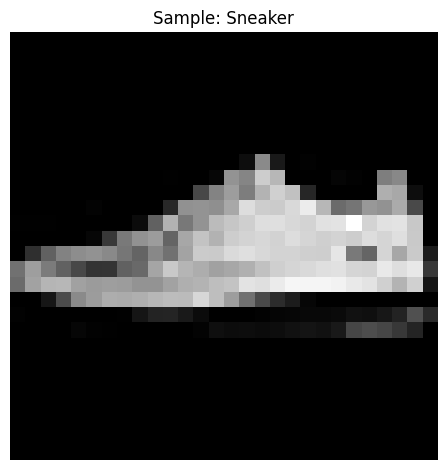

In [38]:
idx = 15
data = single_batch[0][idx].squeeze()
label = single_batch[1][idx]
plt.imshow(data, cmap = "gray")
plt.title(f"Sample: {train_data.classes[label]}")
plt.axis("off")
plt.tight_layout()

In [19]:
torch.manual_seed(42)
conv_layer = nn.Conv2d(
    in_channels=1,    # Canais da imagem de entrada (1 = escala cinza, 3 = rgb)
    out_channels=32,  # Num. canais de saída = num. de filtros
    kernel_size=3,    # Tamanho do filtro
    padding=1,        # Preenchimento ao redor antes de realizar convolução
    stride=1,         # Passo do filtro em cada iteração
)

print(f"Weights: {conv_layer.weight.shape}")
print(f"Biases: {conv_layer.bias.shape}")
print(f"Total parameters: {sum(p.numel() for p in conv_layer.parameters())}")

Weights: torch.Size([32, 1, 3, 3])
Biases: torch.Size([32])
Total parameters: 320


### Feeding forward

In [20]:
input_data = data.unsqueeze(dim=0)
output_data = conv_layer(input_data).detach()

print(f"Input {tuple(input_data.shape)} ->",
      f"Conv(k={conv_layer.kernel_size[0]},",
      f"f={conv_layer.out_channels},",
      f"p={conv_layer.padding[0]},",
      f"s={conv_layer.stride[0]}) ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

Input (1, 28, 28) -> Conv(k=3, f=32, p=1, s=1) -> Output (32, 28, 28)


In [21]:
def plot_layer_fwd(output_data):
  plt.figure(figsize=(20, 10))
  for i in range(len(output_data)):
    plt.subplot(4, 8, i+1)
    plt.imshow(output_data[i], cmap="gray")
    plt.title(f"Filter {i}")
    plt.axis(False)

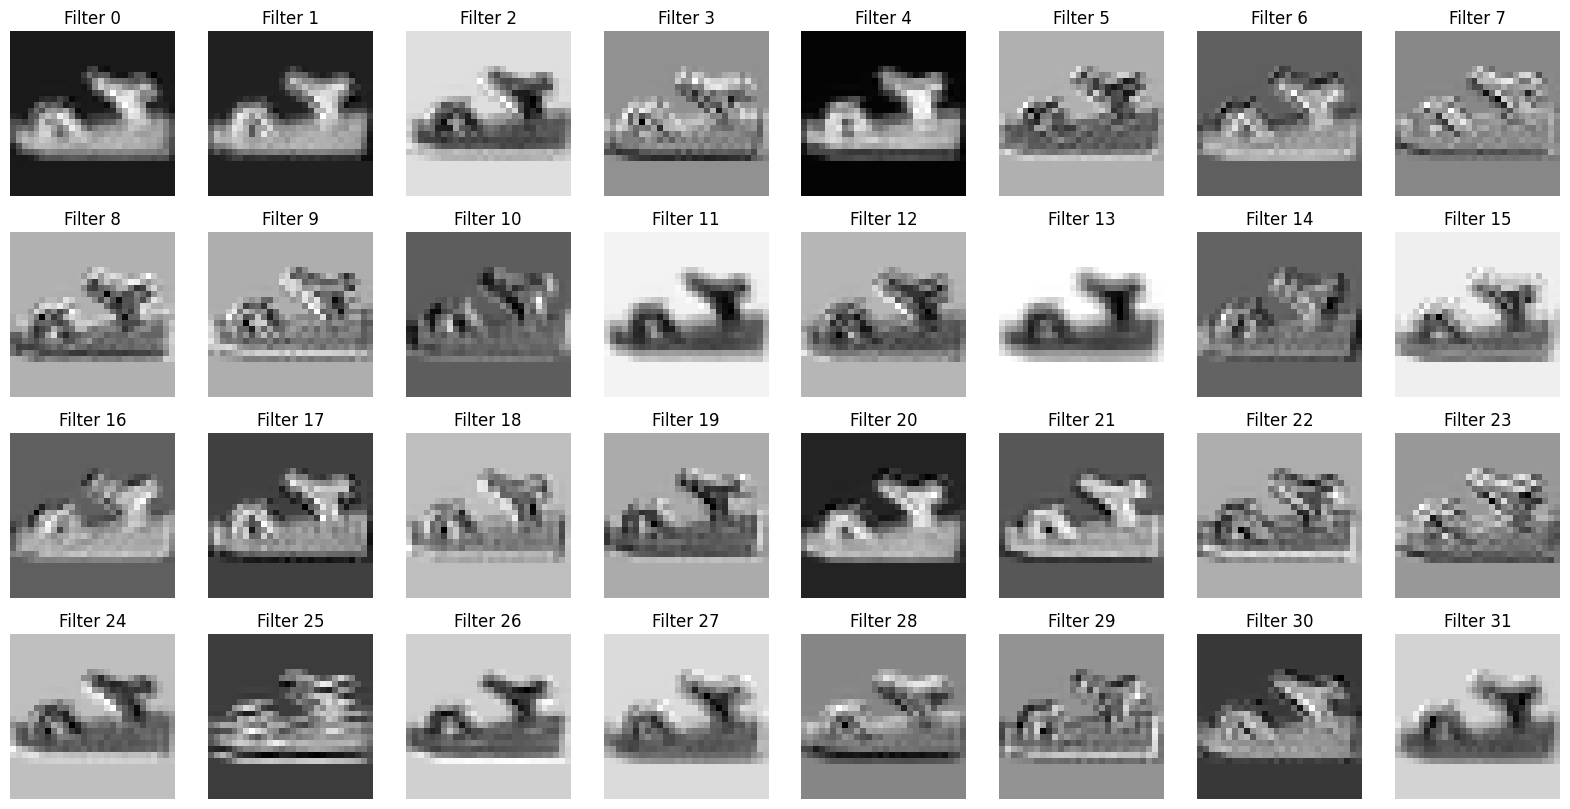

In [22]:
plot_layer_fwd(output_data)

In [23]:
input_data = output_data
relu_layer = nn.ReLU()
output_data = relu_layer(input_data)

print(f"Input {tuple(input_data.shape)} ->",
      f"ReLU ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

Input (32, 28, 28) -> ReLU -> Output (32, 28, 28)


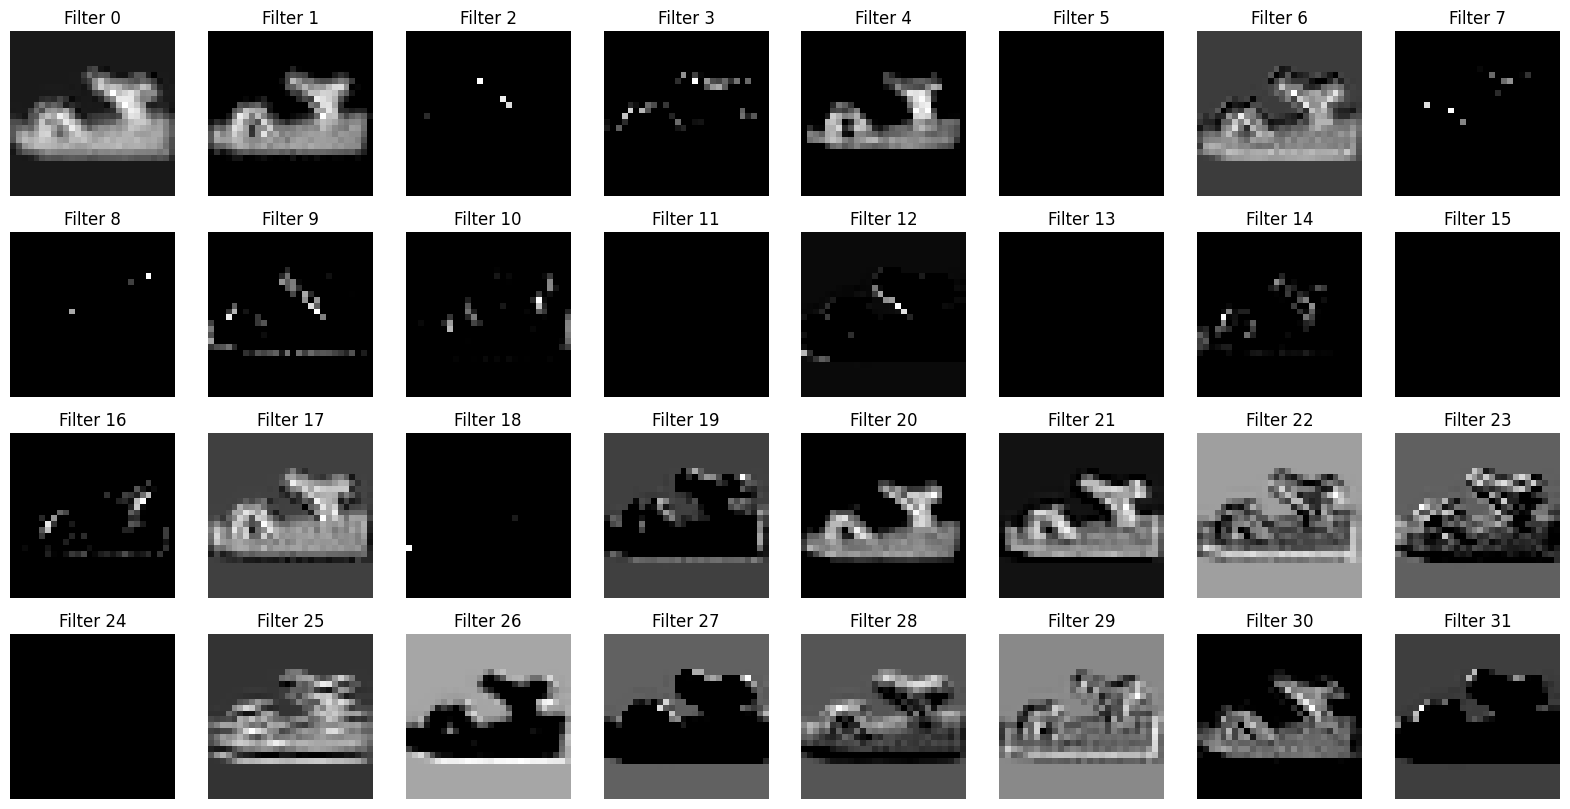

In [24]:
plot_layer_fwd(output_data)

In [25]:
input_data = output_data
maxpool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
output_data = maxpool_layer(input_data)

print(f"Input {tuple(input_data.shape)} ->",
      f"MaxPool(k={maxpool_layer.kernel_size},",
      f"s={maxpool_layer.stride}) ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

Input (32, 28, 28) -> MaxPool(k=2, s=2) -> Output (32, 14, 14)


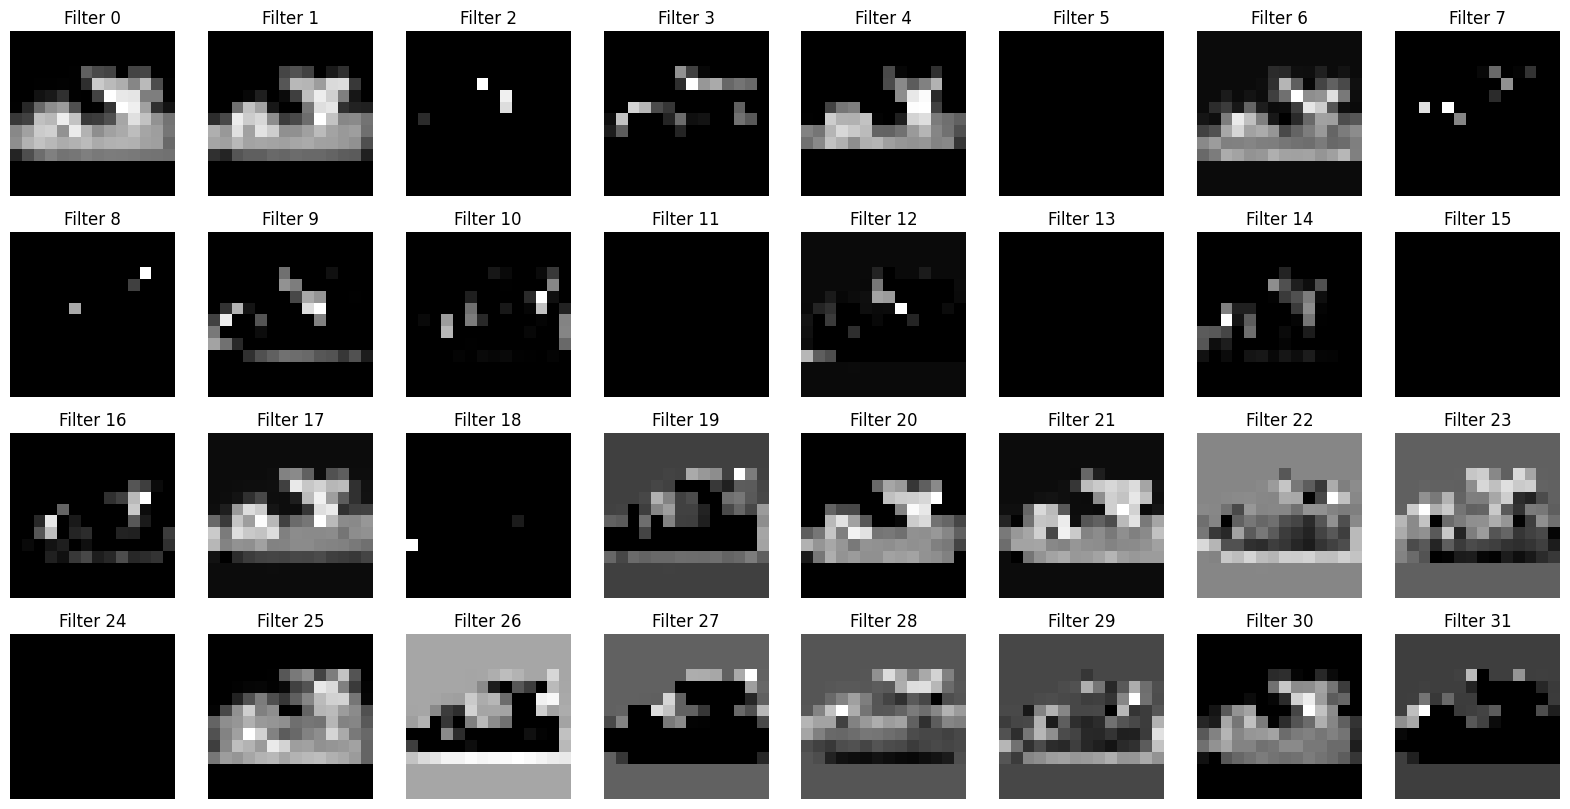

In [26]:
plot_layer_fwd(output_data)

## 10. Trained model under the hood

In [39]:
model_2 = model_2.cpu()
input_data = data.reshape(1, 1, 28, 28)
model_2.eval()
softmax = nn.Softmax(dim=1)
with torch.inference_mode():
  prob = softmax(model_2(input_data))
  idx_max = prob.argmax()
  prob = prob.squeeze().numpy()
  print(f"{np.array2string(prob, precision=5, suppress_small=True)}\nBest: {idx_max} -> {train_data.classes[idx_max]}")
  print(f"sum(p_i) = {sum(prob):.2f}")

[0.00019 0.      0.00001 0.0001  0.00001 0.00013 0.      0.99664 0.00001
 0.00291]
Best: 7 -> Sneaker
sum(p_i) = 1.00


Input (1, 28, 28) -> Conv(k=3, f=32, p=1, s=1) -> Output (32, 28, 28)
Input (32, 28, 28) -> ReLU -> Output (32, 28, 28)
Input (32, 28, 28) -> MaxPool(k=2, s=2) -> Output (32, 14, 14)


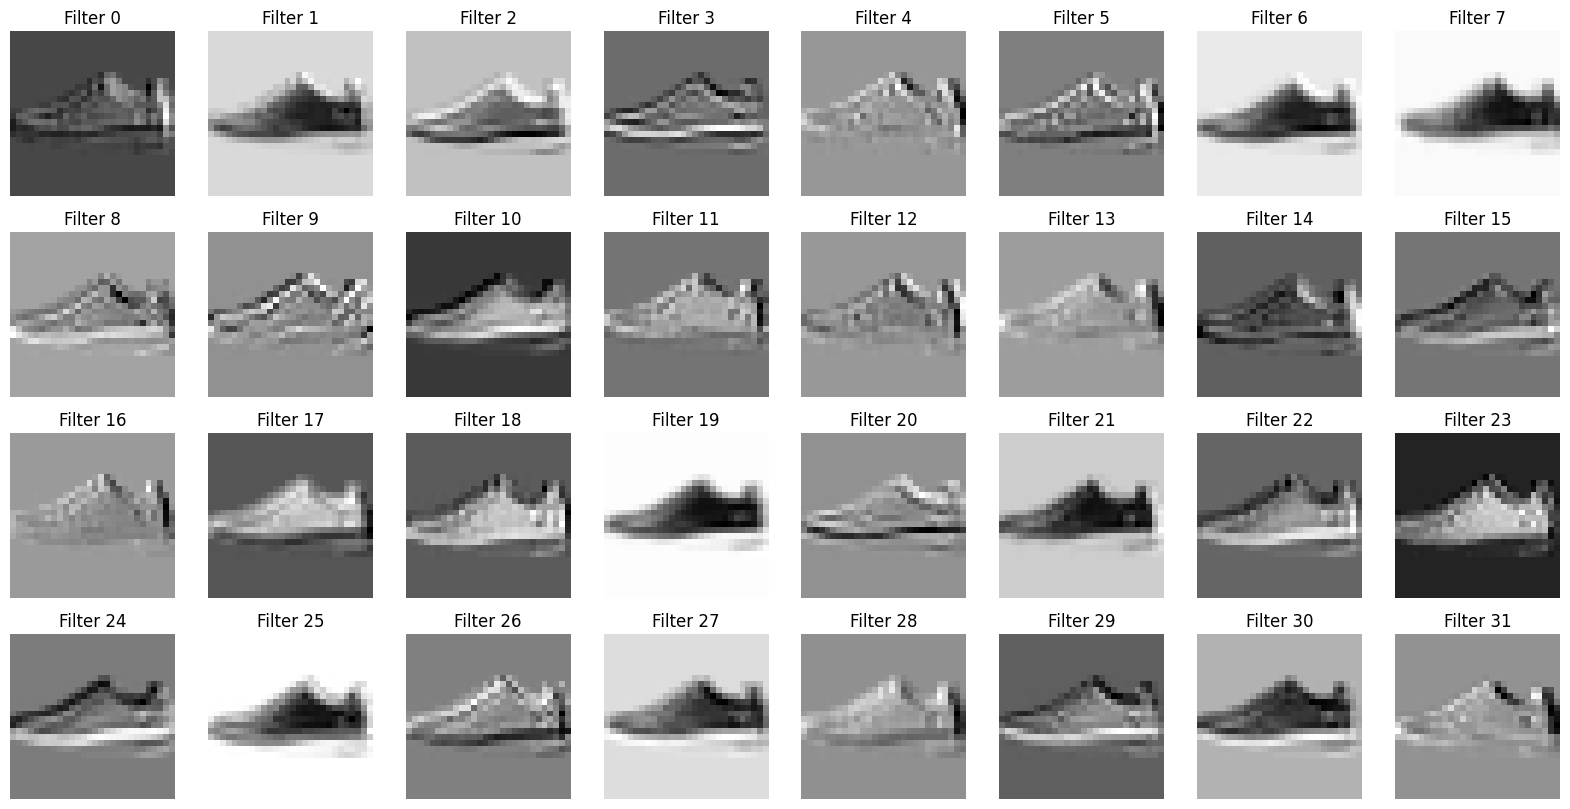

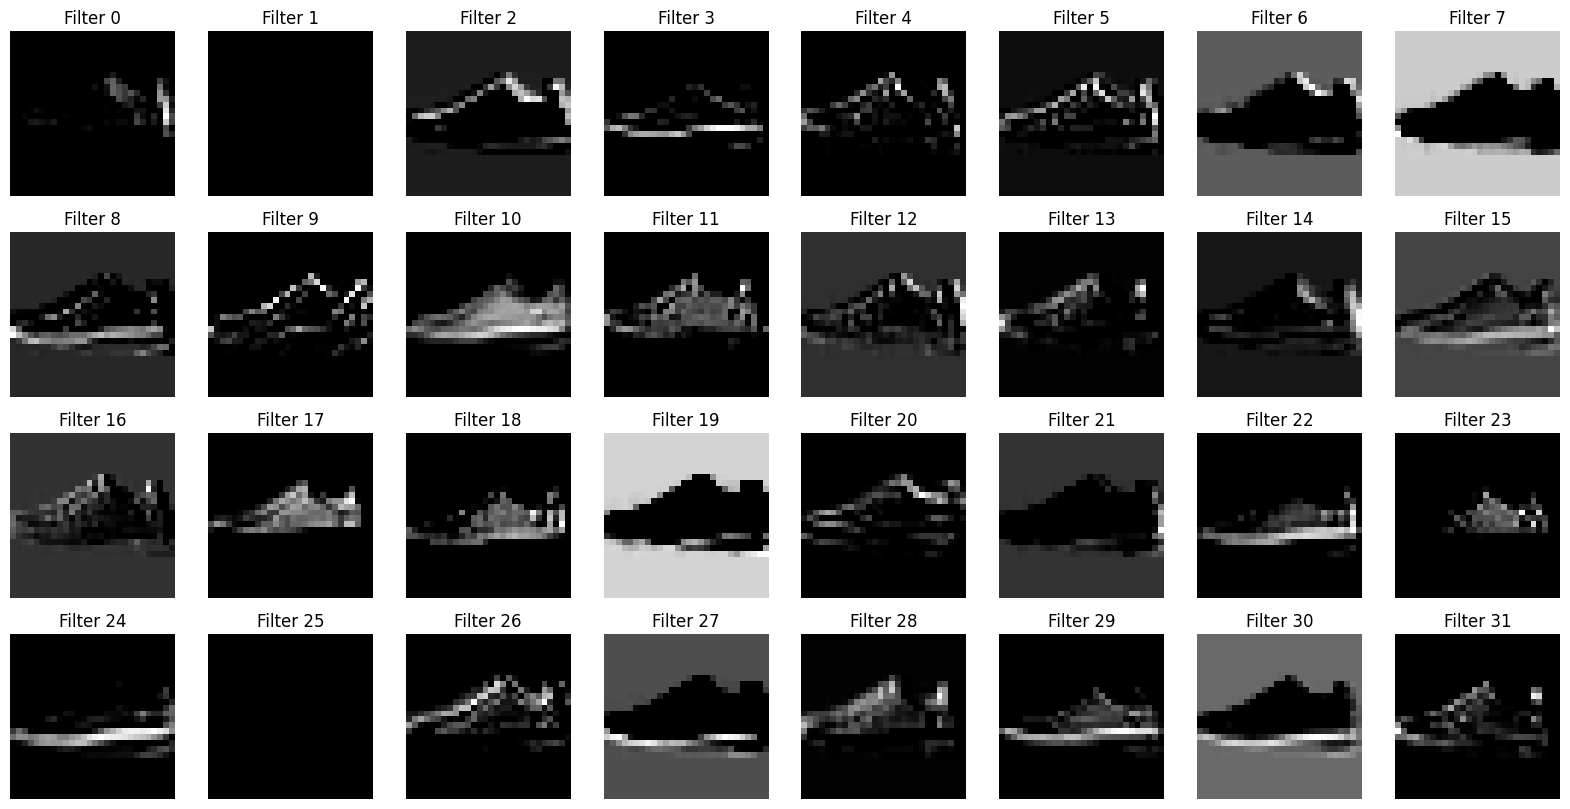

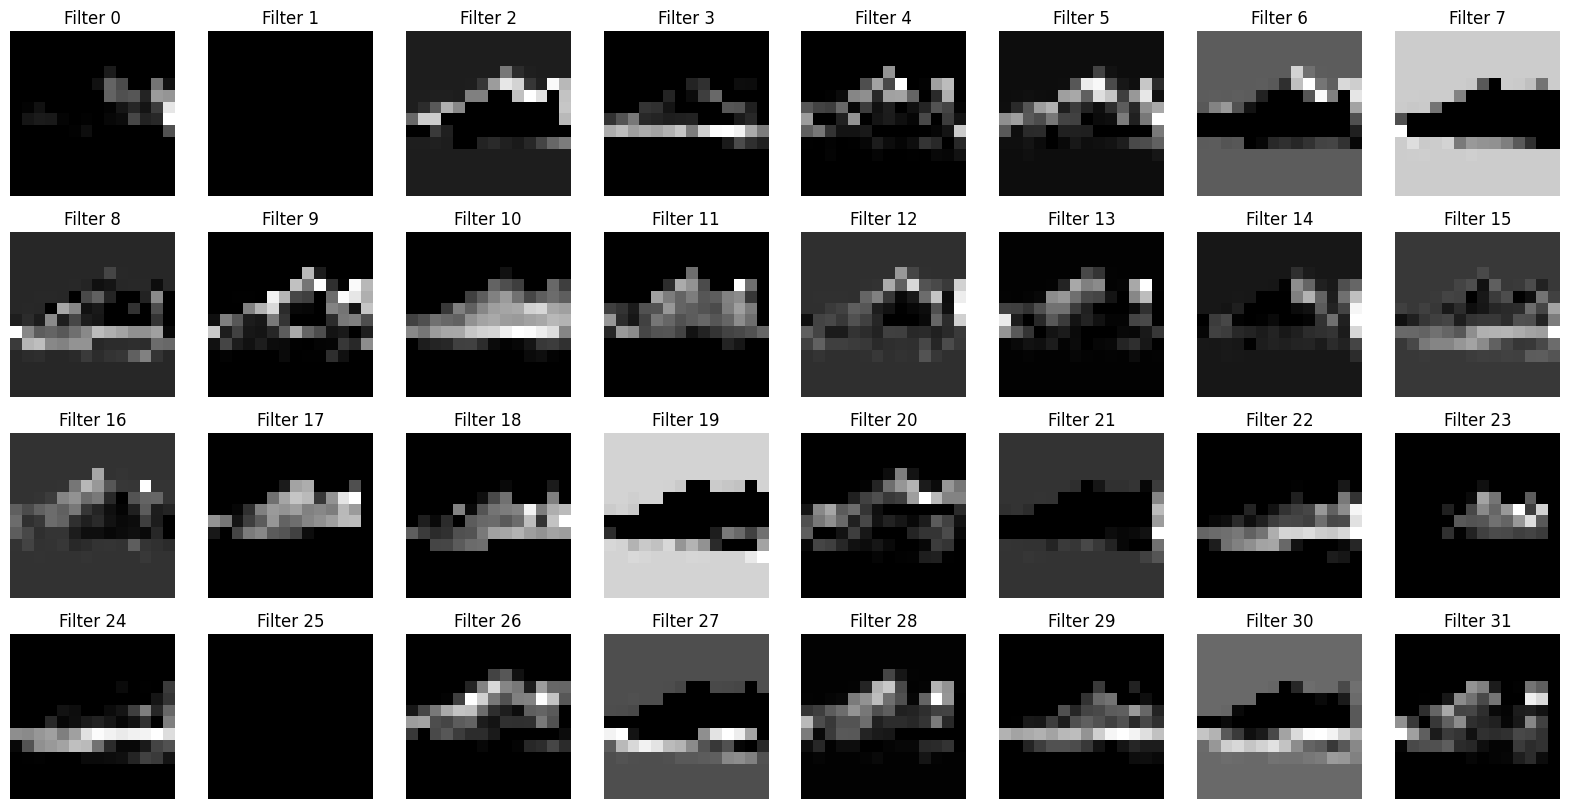

In [40]:
# Layers from trained model
conv_layer = model_2.layer_stack[0]
relu_layer = model_2.layer_stack[1]
maxpool_layer = model_2.layer_stack[2]

input_data = data.unsqueeze(dim=0)
output_data = conv_layer(input_data).detach()

print(f"Input {tuple(input_data.shape)} ->",
      f"Conv(k={conv_layer.kernel_size[0]},",
      f"f={conv_layer.out_channels},",
      f"p={conv_layer.padding[0]},",
      f"s={conv_layer.stride[0]}) ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

plot_layer_fwd(output_data)

input_data = output_data
relu_layer = nn.ReLU()
output_data = relu_layer(input_data)

print(f"Input {tuple(input_data.shape)} ->",
      f"ReLU ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

plot_layer_fwd(output_data)

input_data = output_data
maxpool_layer = nn.MaxPool2d(kernel_size=2, stride=2)
output_data = maxpool_layer(input_data)

print(f"Input {tuple(input_data.shape)} ->",
      f"MaxPool(k={maxpool_layer.kernel_size},",
      f"s={maxpool_layer.stride}) ->",
      f"Output {tuple(output_data.shape)}",
      sep=" ")

plot_layer_fwd(output_data)

## 11. Confusion Matrix

In [20]:
model_2.eval()
with torch.inference_mode():
  y_pred = []
  y_true = []
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model_2(X)
    y_pred += y_logits.argmax(dim=1).tolist()
    y_true += y.tolist()

  0%|          | 0/313 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.80      0.91      0.85      1000
           1       0.99      0.97      0.98      1000
           2       0.77      0.91      0.84      1000
           3       0.91      0.91      0.91      1000
           4       0.90      0.74      0.81      1000
           5       0.99      0.98      0.98      1000
           6       0.77      0.68      0.73      1000
           7       0.96      0.96      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.96      0.97      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



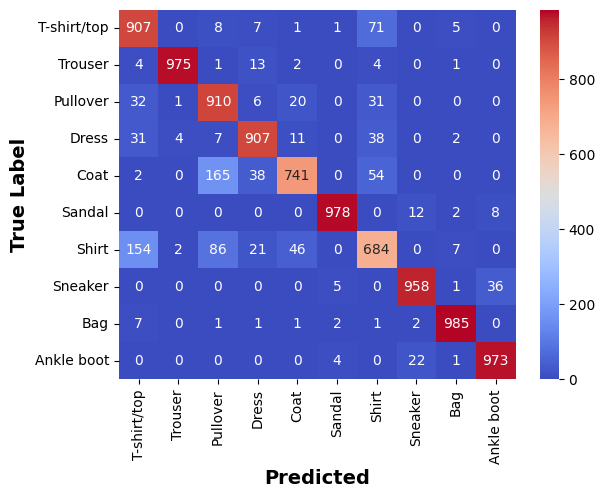

In [39]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=train_data.classes, columns=train_data.classes)
ax = sns.heatmap(cm_df, annot=True, fmt='d', cmap='coolwarm')
fd = dict(weight="bold", size=14)
ax.set_xlabel('Predicted', fontdict=fd)
ax.set_ylabel('True Label', fontdict=fd)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))